<h1>ÉTUDE DE MARCHÉ</h1>

<h2>ABSTRACT</h2>

Cette analyse clustering vise à sélectionner des partenaires commerciaux optimaux dans le secteur de la volaille en se basant sur des **critères spécifiques**. Les résultats, issus de l'affinage des critères, incluant la **distance**, l'**appartenance à l'UE**, la **stabilité politique**, et les considérations **sanitaires**, ont conduit à la sélection des pays tels que l'**Allemagne**, la **Belgique**, l'**Espagne**, les **Pays-Bas**, et la **Pologne**.

Notamment, des exclusions temporaires des **États-Unis** et du **Royaume-Uni** sont motivées par des préoccupations sanitaires, notamment les épidémies d'influenza aviaire et des différences de politiques vaccinales. De même, la stabilité politique est également un critère déterminant, avec l'éviction de pays tels que la **Russie**, en raison de sa situation actuelle.

<h2>SOMMAIRE</h2>

<ol style="list-style-type: none; padding: 0;">
  <li><a href="#code">1. Code</a></li>
  <li><a href="#nettoyage-des-jeux-de-donnees">2. Nettoyage des jeux de données</a>
    <ol style="list-style-type: none; padding-left: 1em;">
      <li><a href="#disponibilite-alimentaire">2.1 Disponibilité alimentaire</a></li>
      <li><a href="#population">2.2 Population</a></li>
      <li><a href="#pib">2.3 PIB</a></li>
      <li><a href="#dataset-final">2.4 Dataset final</a></li>
    </ol>
  </li>
  <li><a href="#normalisation-des-donnees">3. Normalisation des données</a>
    <ol style="list-style-type: none; padding-left: 1em;">
      <li><a href="#split">3.1 Split</a></li>
      <li><a href="#normalisation">3.2 Normalisation</a></li>
    </ol>
  </li>
  <li><a href="#classification-hierarchique">4. Classification hiérarchique</a>
    <ol style="list-style-type: none; padding-left: 1em;">
      <li><a href="#dendrogramme">4.1 Dendrogramme</a></li>
      <li><a href="#caracterisation-des-clusters">4.2 Caractérisation des clusters</a></li>
      <li><a href="#detail">4.3 Détail</a></li>
      <li><a href="#analyse">4.4 Analyse</a></li>
    </ol>
  </li>
  <li><a href="#kmeans">5. KMeans</a>
    <ol style="list-style-type: none; padding-left: 1em;">
      <li><a href="#choix-du-nombre-de-cluster">5.1 Choix du nombre de cluster</a></li>
      <li><a href="#analyse-comparative-des-clustering-hierarchique-et-k-means">5.2 Analyse Comparative des Clustering Hierarchique et K-Means</a></li>
    </ol>
  </li>
  <li><a href="#acp">6. ACP</a>
    <ol style="list-style-type: none; padding-left: 1em;">
      <li><a href="#nombre-de-composante">6.1 Nombre de composante</a></li>
      <li><a href="#correlation">6.2 Corrélation</a></li>
      <li><a href="#projection-des-echantillons">6.3 Projection des échantillons</a></li>
    </ol>
  </li>
  <li><a href="#conclusion">7. Conclusion</a></li>
</ol>


<a id="code" /><h2>1. Code</h2>

<h5>IMPORTS</h5>

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial.distance as sp_distance
from IPython.display import HTML

<h5>PICKLES</h5>

In [2]:
with open('../pkl/dataset.pkl','rb') as f:
    dataset = pickle.load(f)

<h5>STYLER</h5>

In [3]:
matplotlib.style.use('../style/mplstyler.mplstyle')
with open('nbstyler.css','r') as f:
    styler = f.read()
HTML(styler)

<h5>FONCTIONS</h5>

In [4]:
def centroid_country(matrix, df, cluster_map, n_display=5):
    """
    Compute centroids for each cluster and display the top-n countries closest to the centroid.

    Parameters:
    - matrix (np.ndarray): Input matrix representing countries and their features.
    - df (pd.DataFrame): Original dataframe with country information.
    - cluster_map (dict): Dictionary mapping cluster indices to lists of country indices.
    - n_display (int): Number of countries to display for each cluster.

    Returns:
    None
    """
    # Compute centroids and distances
    short_distances = []
    for cluster_indices in cluster_map.values():
        cluster_data = matrix[cluster_indices]
        cluster_mean = cluster_data.mean(axis=0)

        distances = []
        # Calculate distances to centroid
        for index_v, row in enumerate(cluster_data):
            original_index = cluster_indices[index_v]
            distance = sp_distance.euclidean(row, cluster_mean)
            distances.append([original_index, distance])

        # Sort distances and append to the list
        distances = sorted(distances, key=lambda x: x[1])
        short_distances.append(distances)

    # Display results for each cluster
    for i, cluster in enumerate(short_distances):
        idx = [item[0] for item in cluster]
        selected_countries = df.iloc[idx][:n_display]
        text = f"Cluster {i} : {selected_countries.index[0]}"
        text_length = len(text)
        print(f"\n\n{'':>50}{'=':=>{text_length}}")
        print(f"{'':>50}{text}")
        print(f"{'':>50}{'=':=>{text_length}}\n\n")
        display(selected_countries)


def read_projection(df, t_matrix, kmeans_map, dendrogram_map, display_coord=False, **kwargs):
    """
    Generate and yield two DataFrames based on transformed matrix and clustering maps.

    Parameters:
    - df (pd.DataFrame): Original dataframe with country information.
    - t_matrix (np.ndarray): Transformed matrix with components C1 to C4.
    - kmeans_map (dict): Dictionary mapping countries to k-means clusters.
    - dendrogram_map (dict): Dictionary mapping countries to dendrogram clusters.
    - display_coord (bool): Flag indicating whether to display coordinate information.
    - kwargs (dict): Additional keyword arguments for country or coordinate masking.

    Returns:
    - pd.DataFrame: Merged DataFrame with country information and k-means/dendrogram clusters.
    - pd.DataFrame: Transformed matrix subset based on country or coordinate masking.
    """
    # Result dictionary to store the outputs
    result = {}

    # Transform t_matrix to DataFrame
    component_columns = ['C1', 'C2', 'C3', 'C4']
    df_transformed = pd.DataFrame(t_matrix, columns=component_columns)

    # Map clusters to DataFrame
    df_transformed['k_kmeans'] = None
    df_transformed['k_dendrogram'] = None
    for key in map(str, range(5)):
        kmeans_indices, dendrogram_indices = kmeans_map[key], dendrogram_map[key]
        df_transformed.loc[kmeans_indices, 'k_kmeans'] = key
        df_transformed.loc[dendrogram_indices, 'k_dendrogram'] = key

    # Set index with countries
    df_transformed.set_index(df.index, inplace=True)

    # Mask by country
    if 'zone' in kwargs:
        countries_to_mask = kwargs['zone']
        del kwargs['zone']
        pattern = r'|'.join(countries_to_mask)

        # Get the index
        country_mask = df_transformed.index.str.contains(pattern, case=False)

        # Update result dictionary
        result.update({'zone_dataframe': pd.merge(df.loc[country_mask], df_transformed.loc[:, ['k_kmeans', 'k_dendrogram']], on='Zone', how='left')})
        if display_coord:
            result.update({'zone_coordinate': df_transformed.loc[country_mask].round(2)})

    # Mask by coordinates
    if any(x in component_columns for x in kwargs):
        df_selection = df_transformed
        for kwarg_key, kwarg_value in kwargs.items():
            kwarg_value.sort()
            mask = df_selection.loc[:, kwarg_key].between(kwarg_value[0], kwarg_value[1])
            df_selection = df_selection.loc[mask]

        # Get the index
        coordinates_mask = df_selection.index

        # Update result dictionary
        result.update({'component_dataframe': pd.merge(df.loc[coordinates_mask], df_selection.loc[:, ['k_kmeans', 'k_dendrogram']], on='Zone', how='left')})
        if display_coord:
            result.update({'component_coordinate': df_transformed.loc[coordinates_mask].round(2)})

    return result

<a id="nettoyage-des-jeux-de-donnees" /> <h2>2. Nettoyage des jeux de données</h2>

<h3>2.1. Disponibilité alimentaire</h3>

<code>stage_prepare.clean_food_availability_data</code>

**Calcul de la disponibilité alimentaire totale**
- Les lignes de la DataFrame où l'élément est 'Disponibilité alimentaire (Kcal/personne/jour)' sont filtrées pour calculer la disponibilité alimentaire totale par zone.
- Les colonnes inutiles sont supprimées et renommées pour plus de clarté.

**Filtrage des données relatives à la volaille**
- Les données concernant la volaille sont sélectionnées en fonction des produits ('Volaille') et des éléments ('Production', 'Importations - Quantité', 'Exportations - Quantité').
- Les éléments sont renommés pour plus de lisibilité.

**Réorganisation de la DataFrame**
- La DataFrame est remodelée en pivotant les colonnes 'features' pour avoir une structure plus claire.
- Les données inutiles sont supprimées.

**Fusion avec la disponibilité alimentaire totale**
- Les données de disponibilité alimentaire spécifiques à la volaille sont fusionnées avec la disponibilité alimentaire totale par zone.

**Calcul de l'indice de dépendance commerciale (TDI) pour la volaille**
- L'indice TDI pour la volaille est calculé en utilisant les colonnes d'importation, de production et d'exportation de viande de volaille.

**Mise à l'écart des données NaN**
- Près de 40 pays présentent une ou plusieurs données manquantes concernant le produit *volaille*. Un remplacement de ces valeurs par 0 aurait un impact non négligeable sur la distribuion des données. Dès lors, il a été décidé de mettre à l'écart ces pays dans l'attente d'un traitement ultérieur éventuel.

<h3>2.2. Population</h3>

<code>stage_prepare.clean_population_data</code>

**Filtrage des données pour l'année 2017**
- Seules les données relatives à l'année 2017 sont conservées.

**Harmonisation des données**
- Les valeurs de population sont multipliées par 1000.
- La colonne est renommée en 'Population'.

<h3>2.3. PIB</h3>

<code>stage_prepare.clean_gdp_data</code>

**Traitement des données du PIB**
- Une conversion en euros est effectuée en utilisant un taux de change fixe pour l'année 2017.
- La colonne est renommée en 'PIB'.

**Remplacement du nom du pays pour la cohérence**
- Le nom du pays est modifié pour assurer une cohérence.

<h3>2.4. Dataset final</h3>

In [5]:
display(dataset['dataframe'].head(),dataset['dataframe'].info())

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, Afrique du Sud to Îles Salomon
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Production Viande de Volailles    132 non-null    float64
 1   Importations Viande de Volailles  132 non-null    float64
 2   Exportations Viande de Volailles  132 non-null    float64
 3   TDI Volailles                     132 non-null    float64
 4   Ratio d'autosuffisance volailles  132 non-null    float64
 5   Ratio Volailles / viande          132 non-null    float64
 6   Disponibilité totale viande       132 non-null    float64
 7   Disponibilité alimentaire         132 non-null    float64
 8   Population                        132 non-null    int32  
 9   PIB                               132 non-null    float64
 10  PIB par habitant                  132 non-null    float64
dtypes: float64(10), int32(1)
memory usage: 11.9+ KB


,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant
Zone,,,,,,,,,,,
Afrique du Sud,1667.0,514.0,63.0,0.242682,0.787063,0.594734,60.01,2987.0,57009756,3.377010e+11,5924.0
Albanie,13.0,38.0,0.0,0.745098,0.254902,0.344349,47.51,3400.0,2884169,1.154459e+10,4003.0
Algérie,275.0,2.0,0.0,0.007220,0.992780,0.353463,18.05,3345.0,41389189,1.508250e+11,3644.0
Allemagne,1514.0,842.0,646.0,0.492398,0.885380,0.221805,87.78,3559.0,82658409,3.272676e+12,39593.0
Angola,42.0,277.0,0.0,0.868339,0.131661,0.449744,23.48,2266.0,29816766,1.082872e+11,3632.0


None

<a id="normalisation-des-donnees"/> <h2>3. Normalisation des données</h2>

Avant d'appliquer des techniques de clustering, il est essentiel de **normaliser** et **transformer** les données. Cela devient particulièrement important lorsque le jeu de données utilise des unités différentes. La **normalisation**, réalisée en **centrant** et **réduisant** les données, assure une échelle cohérente entre les variables, évitant les biais potentiels dus aux différentes unités de mesure. L'utilisation d'outils tels que la bibliothèque `sklearn.preprocessing...`, avec la méthode de transformation '**Yeo Johnson**', est recommandée. Ces techniques ajustent la distribution des données, les rendant plus adaptées aux algorithmes de clustering.
Ici nous appliquerons la méthode des quantiles `sklearn.preprocessing.QuantileTransformer` 

<h3>3.1. Split : séparer la matrice de données des noms de variables et échantillons</h3>

**Matrice**

In [6]:
dataset['matrix']

array([[1.66700000e+03, 5.14000000e+02, 6.30000000e+01, ...,
        5.70097560e+07, 3.37700975e+11, 5.92400000e+03],
       [1.30000000e+01, 3.80000000e+01, 0.00000000e+00, ...,
        2.88416900e+06, 1.15445945e+10, 4.00300000e+03],
       [2.75000000e+02, 2.00000000e+00, 0.00000000e+00, ...,
        4.13891890e+07, 1.50824999e+11, 3.64400000e+03],
       ...,
       [3.40000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
        1.67853610e+07, 9.24791408e+10, 5.51000000e+03],
       [2.19140000e+04, 1.23000000e+02, 3.69200000e+03, ...,
        3.25084756e+08, 1.72705547e+13, 5.31260000e+04],
       [0.00000000e+00, 6.00000000e+00, 0.00000000e+00, ...,
        6.36039000e+05, 1.30326319e+09, 2.04900000e+03]])

**Features**

In [7]:
for i,(k,v) in zip(range(3),dataset['features'].items()):
    print(k,v)
print('...')

F0 Production Viande de Volailles
F1 Importations Viande de Volailles
F2 Exportations Viande de Volailles
...


**Samples**

In [8]:
for i,(k,v) in zip(range(3),dataset['samples'].items()):
    print(k,v)
print('...')

S0 Afrique du Sud
S1 Albanie
S2 Algérie
...


<h3>3.2. Normalisation des données</h3>

Pour évaluer la normalité d'une distribution de données, plusieurs tests statistiques sont disponibles, tels que le test de **Shapiro-Wilk**, le test de **Kolmogorov-Smirnov**, et d'autres. Ces tests sont particulièrement utiles lorsqu'un jeu de données comporte un grand nombre de variables. Cependant, au vu du petit nombre de variables dans cette analyse, nous opterons pour une approche visuelle afin d'évaluer les distributions.

**Distributions originales**

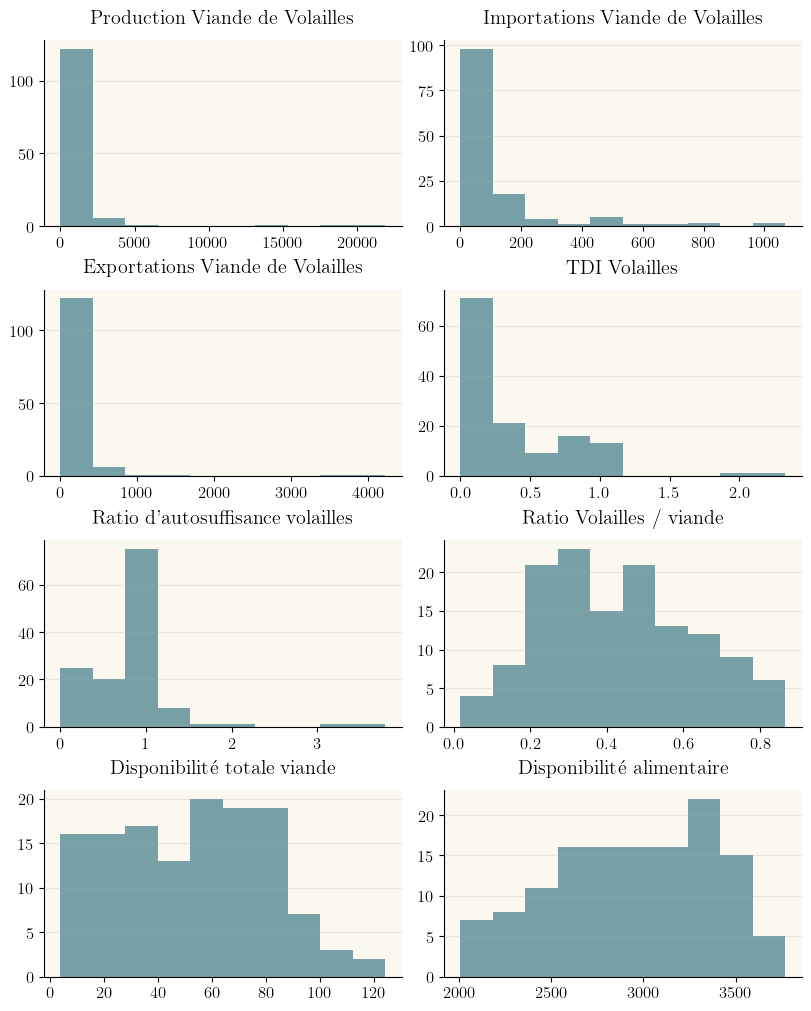

In [9]:
def fcell(dataset):
    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(8,10),layout='constrained')
    feature_index = 0
    for rowax in range(ax.shape[0]):
        for colax in range(ax.shape[1]):
            ax[rowax][colax].hist(dataset.iloc[:,feature_index])
            ax[rowax][colax].set_title(dataset.columns[feature_index],pad=12)
            feature_index += 1

fcell(dataset['dataframe'])

**Distributions après transformation**

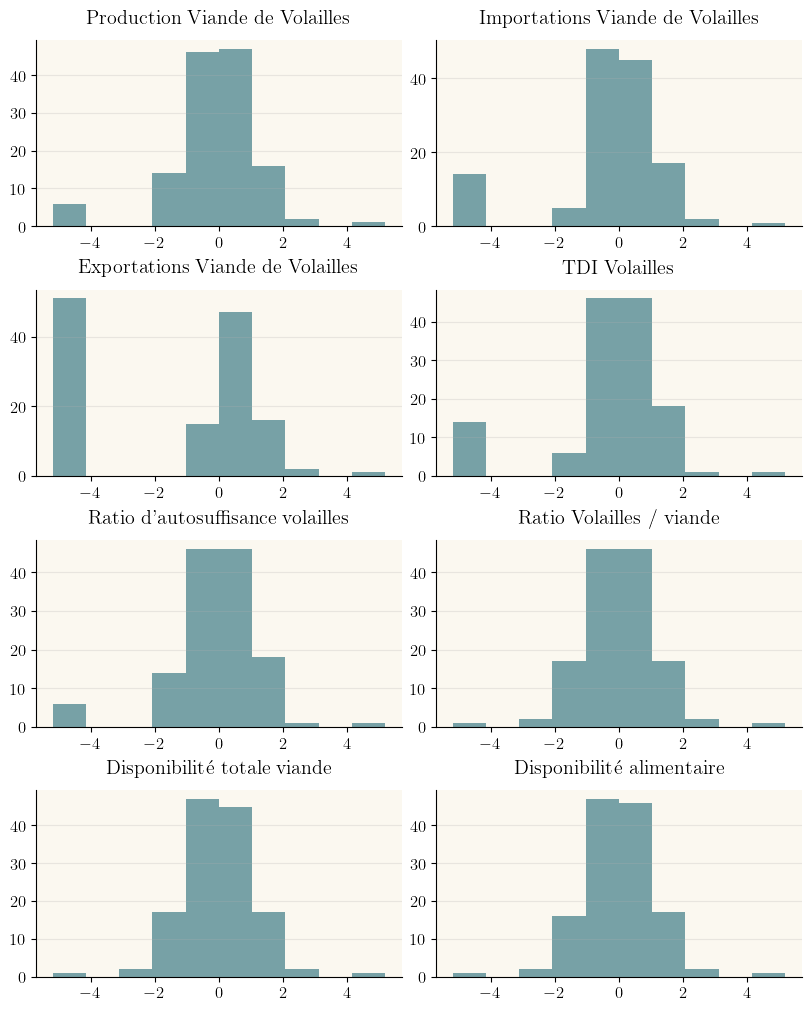

In [10]:
def fcell(scaled_matrix,feature):
    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(8,10),layout='constrained')
    feature_index = 0
    for rowax in range(ax.shape[0]):
        for colax in range(ax.shape[1]):
            ax[rowax][colax].hist(scaled_matrix[:,feature_index],bins=10)
            ax[rowax][colax].set_title(feature[feature_index],pad=12)
            feature_index += 1

fcell(dataset['scaled_matrix'],list(dataset['features'].values()))

<a id="classification-hierarchique" /><h2>4. Classification hiérarchique</h2>

La **classification hiérarchique** est une méthode d'analyse statistique qui regroupe des données similaires dans une structure arborescente. La méthode de **Ward**, souvent utilisée dans cette approche, vise à minimiser la diminution de l'*inertie intraclasse* lors de la fusion de groupes, où l'inertie mesure la dispersion des données à l'intérieur de chaque groupe. Le dendrogramme résultant illustre la hiérarchie des regroupements et permet de visualiser les relations de similarité entre les éléments étudiés.

L'utilisation de la bibliothèque `scipy.cluster.hierarchy` facilite l'implémentation de la **classification hiérarchique** en fournissant des outils efficaces pour construire des dendrogrammes et effectuer ce type d'analyse.

<h3>4.1. Dendrogramme</h3>

<img src='../plot/dendrogram.png' />

**Analyse**

La classification hiérarchique met en évidence l'existence de trois clusters principaux *(t=30)* avec un cluser 0 initial de taille importante. En choisissant une classification à cinq clusters, nous parvenons à obtenir une analyse plus approfondie du cluster 0 initial. Nous allons procéder à une première analyse parallèle des centroïds (a), suivie d'une analyse plus détaillée des clusters retenus (b).

<h3>4.2. Caractérisation des clusters</h3>

<img src='../plot/centroid.png' />

**Pays les plus représentatifs**  

Le calcul de la distance euclidienne aux moyennes de chaque éléments nous permets de déterminer le pays le plus proche de chaque centroïd.

In [11]:
centroid_country(dataset['scaled_matrix'],dataset['dataframe'],dataset['dendrogram_cluster'],1)



                                                  Cluster 0 : France




,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant
Zone,,,,,,,,,,,
France,1750.0,506.0,501.0,0.288319,0.997151,0.275771,83.04,3556.0,64842509,2.301120e+12,35488.0




                                                  Cluster 1 : Costa Rica




,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant
Zone,,,,,,,,,,,
Costa Rica,133.0,17.0,3.0,0.115646,0.904762,0.495238,53.55,3013.0,4949954,5.365958e+10,10840.0




                                                  Cluster 2 : Sénégal




,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant
Zone,,,,,,,,,,,
Sénégal,77.0,0.0,0.0,0.0,1.0,0.33711,14.12,2611.0,15419355,1.861766e+10,1207.0




                                                  Cluster 3 : Antigua-et-Barbuda




,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant
Zone,,,,,,,,,,,
Antigua-et-Barbuda,0.0,7.0,0.0,1.0,0.0,0.751076,72.03,2429.0,95426,1.301656e+09,13640.0




                                                  Cluster 4 : République de Moldova




,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant
Zone,,,,,,,,,,,
République de Moldova,54.0,16.0,0.0,0.228571,0.771429,0.4234,38.12,2397.0,4059684,8.574160e+09,2112.0


<h3>4.3. Détails cluster 0 & 1</h3>

**Box plot clusters 0 & 1**

<img src='../plot/boxplot.png' />

<h3>4.4. ANALYSE</h3>

**Projection géographique des clusters**

<img src='../plot/geomap_dendrogram.png' />

**Cluster 0**

Les pays appartenant au cluster **0** se distinguent par des caractéristiques économiques marquées, notamment des *importations significatives*, une *production robuste*, et un *PIB élevé*. Ce cluster englobe les principales puissances économiques mondiales telles que les États-Unis, la Chine, l'Allemagne, le Royaume-Uni, la France, l'Italie, le Brésil et le Canada. L'examen des centroïdes révèle que la France est l'un des pays dont les caractéristiques représentent ce groupe.

**Cluster 1**

Les pays du cluster **1** maintiennent des moyennes globalement plus élevées que les *clusters 2, 3 et 4*, bien qu'ils ne surpassent pas ceux du cluster 0. Ce groupe comprend des pays d'Europe de l'Est, d'Amérique du Sud et du Moyen-Orient.

**Clusters 2, 3 et 4**

Les *clusters 2, 3 et 4* regroupent des pays présentant des caractéristiques communes telles que des *ressources insuffisantes*, une dépendance limitée au *commerce extérieur*, ou une *population faible*. Ces clusters indiquent des positions économiques potentiellement moins favorables.


<a id="kmeans" /><h2>5. K-means</h2>

Afin de confirmer notre analyse une deuxième méthode de clusturring a été réalisée.

<h3>5.1. Choix du nombre de clusters</h3>

Plusieurs méthodes sont employées pour évaluer la qualité de la partition, dont la **méthode de la silhouette** et la **méthode du coude**.

**Méthode du Silhouette score**  
La méthode de la silhouette évalue la cohésion et la séparation des clusters. Le score de silhouette mesure à quel point un objet est similaire à son propre cluster (cohésion) par rapport aux autres clusters (séparation). Un score élevé indique une partition appropriée.

**Méthode du Coude**  
La méthode du coude est choisie pour sa **simplicité de mise en place**. Elle consiste à identifier le nombre optimal de clusters en observant le point où l'ajout de clusters ne contribue que marginalement à la réduction de l'inertie.

Un coude franc est observé pour **3 clusters**, en corrélation avec le dendrogramme. Toutefois, pour une analyse plus approfondie et comparée, une approche avec **5 clusters** est retenue.

<img src='../plot/elbow.png' />

<h3>5.2. Analyse Comparative des Clustering Hierarchique et K-Means</h3>

L'examen des résultats obtenus par les méthodes de **clustering hiérarchique** et **k-means** révèle une **similitude marquante** dans la structuration des groupes. Les **différences notables** se manifestent principalement entre les **clusters 0 et 1**, ce qui peut être attribué à la **proximité des échantillons** au sein de ces groupes.

L'observation de la courbe d'Elbow confirme cette observation en suggérant une **moins bonne distinction entre cinq clusters** par rapport à trois. La **pente de la courbe** indique que l'ajout de clusters au-delà de trois n'apporte pas une amélioration significative dans la représentation des données, suggérant ainsi **une partition en trois clusters**.

In [12]:
print("Test des similarité\n\n")

for cluster_key in map(str,range(5)):
    n_symdiff = len(set(dataset['kmeans_cluster'][cluster_key]).symmetric_difference(set(dataset['dendrogram_cluster'][cluster_key])))
    print(f"Différence symétrique kmeans et dendrogramme cluster {cluster_key} : {n_symdiff} éléments.")
    if n_symdiff > 0:
        intersect = set(dataset['kmeans_cluster'][cluster_key]).intersection(set(dataset['dendrogram_cluster'][cluster_key]))

Test des similarité


Différence symétrique kmeans et dendrogramme cluster 0 : 12 éléments.
Différence symétrique kmeans et dendrogramme cluster 1 : 12 éléments.
Différence symétrique kmeans et dendrogramme cluster 2 : 0 éléments.
Différence symétrique kmeans et dendrogramme cluster 3 : 0 éléments.
Différence symétrique kmeans et dendrogramme cluster 4 : 0 éléments.


<a id="acp"/><h2>6. ACP</h2>

L'**Analyse des Composantes Principales (ACP)** est une méthode statistique qui simplifie les données en réduisant leur dimension tout en préservant l'information essentielle. Elle permet de visualiser les relations complexes entre les variables.

Dans le cas présent, le nombre de variables est assez faible *(n=11)* cependant, l'ACP permet de confirmer les analyses réalisées précédemment.

<h3>6.1. Choix du nombre de composantes</h3>

<img src='../plot/scree.png' />

<h3>6.2. Corrélations</h3>

<img src='../plot/heatmap.png' />

<img src='../plot/correlation_0.png' />

<img src='../plot/correlation_1.png' />

<h3>6.3. Projection des échantillons</h3>

<img src='../plot/projection_0.png' />

<img src='../plot/projection_1.png' />

La projections des échantillons donne une confirmation visuelle de la proximité des groupes 0 et 1.  

La fonction ```read_projection``` permet de lire la projection des échantillons sur les axes C1,C2 et C3.

In [13]:
df= read_projection(
    df=dataset['dataframe'],
    t_matrix=dataset['transformed_matrix'],
    kmeans_map=dataset['kmeans_cluster'],
    dendrogram_map=dataset['dendrogram_cluster'],
    display_coord=True,
    C1=[-4,-np.inf],
    C2=[-5,-np.inf]
)
df['component_coordinate'].sort_values('C1')

,C1,C2,C3,C4,k_kmeans,k_dendrogram
Zone,,,,,,
Dominique,-6.50,-6.27,3.54,-1.36,3,3
Îles Salomon,-6.16,-5.12,1.57,-2.18,3,3
Saint-Kitts-et-Nevis,-6.05,-6.63,4.40,-0.17,3,3
Antigua-et-Barbuda,-5.65,-5.88,2.98,-0.80,3,3
Samoa,-5.39,-6.15,2.80,-0.23,3,3


<a id="conclusion"><h2>7. CONCLUSION</h2>

In [14]:
# Selection des pays candidats dans l'intersection des clusters 0 du dendrogramme et k-means
idx = list(set(dataset['dendrogram_cluster']['0']).intersection(set(dataset['kmeans_cluster']['0'])))
zone_selection = dataset['dataframe'].iloc[idx].index.to_list()
zone_selection.sort()

df = read_projection(
    df=dataset['dataframe'],
    t_matrix=dataset['transformed_matrix'],
    kmeans_map=dataset['kmeans_cluster'],
    dendrogram_map=dataset['dendrogram_cluster'],
    zone=zone_selection+['arabie']
)

La DataFrame ci-dessous présente les pays cibles initiaux en se basant sur des critères spécifiques pour caractériser les pays candidats. Cependant, pour affiner cette sélection, plusieurs autres critères doivent être pris en compte :

- **Distance par rapport à la France :** L'influence de la distance sur les coûts globaux d'import/export nécessite une attention particulière.

- **Appartenance à l'Union Européenne (U.E) :** Les transactions intra-européennes sont régies par des lois communes, ce qui simplifie les échanges.

- **Stabilité Politique :** La stabilité politique est cruciale, notamment en évitant les régions en proie à des conflits. Par exemple, la situation actuelle en Russie est une raison d'exclusion.

Suite à la mise à jour de ces critères, les pays retenus sont :

- Allemagne,
- Royaume-Uni
- Belgique,
- Espagne,
- Pays-Bas,
- Pologne.
- Arabie Saoudite *

*Note concernant les USA,Japon et Canada :*

L'épidémie d'influenza aviaire et les différences dans les politiques vaccinales excluent ces pays pour le moment.

\* Bien que ne figurant que dans la classification hiérarchique, l'Arabie Saoudite se distingue par l'importation de 722 milliers de tonnes de volailles, avec un ratio volaille/viande dépassant les 80%. Ce pays est un partenaire commercial de la France dans plusieurs secteurs dont celui de la volaille. Cependant, il est impératif de prendre en considération les préoccupations éthiques liées aux droits de l'homme lors de l'évaluation de cette possibilité.

In [15]:
df['zone_dataframe'].sort_values('Importations Viande de Volailles',ascending=False)

,Production Viande de Volailles,Importations Viande de Volailles,Exportations Viande de Volailles,TDI Volailles,Ratio d'autosuffisance volailles,Ratio Volailles / viande,Disponibilité totale viande,Disponibilité alimentaire,Population,PIB,PIB par habitant,k_kmeans,k_dendrogram
Zone,,,,,,,,,,,,,
Japon,2215.0,1069.0,10.0,0.326512,0.676542,0.375025,49.33,2699.0,127502725,4.372173e+12,34291.0,0,0
Mexique,3249.0,972.0,9.0,0.230769,0.771368,0.501310,64.87,3258.0,124777324,1.027607e+12,8236.0,0,0
Allemagne,1514.0,842.0,646.0,0.492398,0.885380,0.221805,87.78,3559.0,82658409,3.272676e+12,39593.0,0,0
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,1814.0,779.0,359.0,0.348702,0.811996,0.399750,79.90,3428.0,66727460,2.379370e+12,35658.0,0,0
Arabie saoudite,616.0,722.0,10.0,0.543675,0.463855,0.801183,54.12,3194.0,33101178,6.105693e+11,18446.0,1,0
Pays-Bas,1100.0,608.0,1418.0,2.096552,3.793103,0.268206,75.80,3251.0,17021347,7.393922e+11,43439.0,0,0
France,1750.0,506.0,501.0,0.288319,0.997151,0.275771,83.04,3556.0,64842509,2.301120e+12,35488.0,0,0
"Chine, continentale",18236.0,452.0,576.0,0.024956,1.006846,0.205843,59.90,3197.0,1421021791,1.091571e+13,7682.0,0,0
Belgique,463.0,338.0,656.0,2.331034,3.193103,0.192308,65.78,3770.0,11419748,4.458015e+11,39038.0,0,0
